In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
from tqdm import tqdm
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [2]:
means = [0.4914, 0.4822, 0.4465]
stds = [0.2470, 0.2435, 0.2616]

train_transforms = A.Compose(
    [
        
        A.Normalize(mean=means, std=stds, always_apply=True),
        A.PadIfNeeded(min_height=4, min_width=4, always_apply=True),
        A.RandomCrop(height=32, width=32, always_apply=True),
        A.HorizontalFlip(),
        A.CoarseDropout(max_holes=1, max_height=8, max_width=8, min_holes=1, min_height=8, min_width=8, fill_value=means),
        ToTensorV2(),
    ]
)

test_transforms = A.Compose(
    [
        A.Normalize(mean=means, std=stds, always_apply=True),
        ToTensorV2(),
    ]
)

In [3]:
class Cifar10SearchDataset(datasets.CIFAR10):

    def __init__(self, root="~/data", train=True, download=True, transform=None):

        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):

        image, label = self.data[index], self.targets[index]

        if self.transform is not None:

            transformed = self.transform(image=image)

            image = transformed["image"]

        return image, label

In [4]:
train = Cifar10SearchDataset(root='./data', train=True,
                                        download=True, transform=train_transforms)
test = Cifar10SearchDataset(root='./data', train=False,
                                       download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=0, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? False


In [6]:
import torch
import torch.nn as nn


def prepblock( # Preparation block
    i:int, # in_channels
    o:int, # out_channels
) -> nn.Sequential:
    "Use 3x3 convolution to create more channels."
    return nn.Sequential(
        nn.Conv2d(i, o, 3, padding=1, padding_mode='replicate', bias=False),
        nn.BatchNorm2d(o),
        nn.ReLU(),
    )


def convblock( # Convolution block
    i:int, # in_channels
    o:int, # out_channels
) -> nn.Sequential:
    "Use 3x3 convolution to extract features."
    return nn.Sequential(
        nn.Conv2d(i, o, 3, padding=1, padding_mode='replicate', bias=False),
        nn.MaxPool2d(2, stride=2),
        nn.BatchNorm2d(o),
        nn.ReLU(),
    )


def resblock( # Residual block
    i:int, # in_channels
    o:int, # out_channels
) -> nn.Sequential:
    "Use two 3x3 convolution layers for the residual path."
    return nn.Sequential(
        nn.Conv2d(i, o, 3, padding=1, padding_mode='replicate', bias=False),
        nn.BatchNorm2d(o),
        nn.ReLU(),
        nn.Conv2d(o, o, 3, padding=1, padding_mode='replicate', bias=False),
        nn.BatchNorm2d(o),
        nn.ReLU(),
    )


def predblock( # Prediction block
    i:int, # in_channels
    o:int, # out_channels
) -> nn.Sequential:
    "Use max pooling and 1x1 convolution to compute logit for loss function"
    return nn.Sequential(
        # [-1, i, s, s]
        nn.MaxPool2d(4),
        # [-1, i, 1, 1]
        nn.Conv2d(i, o, 1, padding=0, bias=False),
        # [-1, o, 1, 1]
        nn.Flatten(),
        # [-1, o]
    )


class SkipBlock(nn.Module):
    "Convolution layers with identity and residual paths"
    def __init__(self,
        i:int, # in_channels
        o:int, # out_channels
    ) -> None:
        super().__init__()
        self.conv = convblock(i, o)
        self.res = resblock(o, o)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv(x)
        y = self.res(x)
        return x + y


class Res_Net(nn.Module):
    "Optimized ResNet from https://github.com/davidcpage/cifar10-fast"
    def __init__(self) -> None:
        super().__init__()
        self.conv0 = prepblock(3, 64)
        self.conv1 = SkipBlock(64, 128)
        self.conv2 = convblock(128, 256)
        self.conv3 = SkipBlock(256, 512)
        self.trans = predblock(512, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv0(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.trans(x)
        return x

In [7]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Res_Net().to(device)
summary(model, input_size=(3, 32, 32))

cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
        SkipBlock-14          [-1, 

In [8]:
import torch
from tqdm.auto import tqdm
def count_correct_predictions(predictions,labels,):
    "Count how many predictions match corresponding labels."
    return predictions.argmax(dim=1).eq(labels).sum().item()


In [31]:
from tqdm import tqdm

train_loss = []
train_acc =  []
test_loss =  []
test_acc = []

def train_step (device, train_loader,model,criterion, optimizer,scheduler,epoch,onecyclelr:bool=True):
    model.train()
    train_loss = 0
    correct = 0
    processed = 0
    epoch += 1
    pbar = tqdm(train_loader)
    for batch, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        pred = model(data)
        loss = criterion(pred, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if onecyclelr: scheduler.step()
        train_loss += loss.item()
        correct += count_correct_predictions(pred, target)
        processed += len(data)
        pbar.set_description(desc=(
            f"Epoch = {epoch}, "
            f"Batch = {batch}, "
            f"Loss = {loss.item():0.4f}, "
            f"Accuracy = {correct/processed:0.2%}"
        ))
    if not onecyclelr: scheduler.step()
    n = len(train_loader.dataset)
    train_loss /= n
    train_acc = correct / n
    print(
        f"Train: "
        f"Loss = {train_loss:0.5f}, "
        f"Accuracy = {train_acc:0.2%}, "
        f"Epoch = {epoch}"
    )
    return train_loss, train_acc
  
def test_step (device,test_loader,model,criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            pred = model(data)
            loss = criterion(pred, target)
            test_loss += loss.item()
            correct += count_correct_predictions(pred, target)
    n = len(test_loader.dataset)
    test_loss /= n
    test_acc = correct / n
    print(
        f"Test : "
        f"Loss = {test_loss:.5f}, "
        f"Accuracy = {test_acc:.2%}\n"
    )
    return test_loss, test_acc

def train(device,train_loader,test_loader,model,criterion,optimizer,scheduler,epochs:int,onecyclelr:bool=True):
    "Train and test for given epochs and return the results."
    results = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': [],
    }
    for epoch in range(epochs):
        train_loss, train_acc = train_step(
            device,
            train_loader,
            model,
            criterion,
            optimizer,
            scheduler,
            epoch,
            onecyclelr=onecyclelr,
        )
        test_loss, test_acc = test_step(
            device,
            test_loader,
            model,
            criterion,
        )
        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc*100)
        results['test_loss'].append(test_loss)
        results['test_acc'].append(test_acc*100)
    return results


  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.26E-02


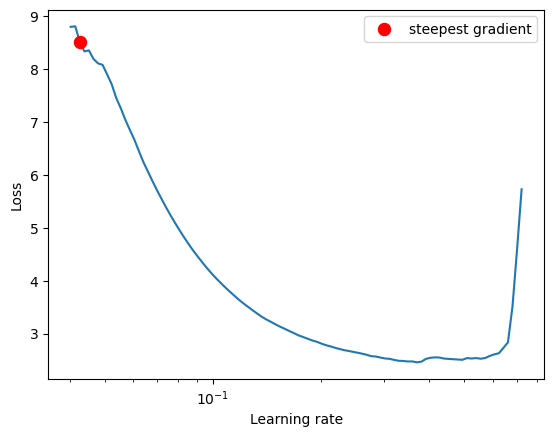

(<AxesSubplot:xlabel='Learning rate', ylabel='Loss'>, 0.04258480338069861)

In [10]:
from torch_lr_finder import LRFinder

model = Res_Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.03, weight_decay=1E-4)
criterion = nn.CrossEntropyLoss()
lr_finder = LRFinder(model, optimizer, criterion, device="cpu")
lr_finder.range_test(train_loader, end_lr=10, num_iter=200, step_mode="exp")
lr_finder.plot() # to inspect the loss-learning rate graph

In [ ]:

from torch.optim.lr_scheduler import OneCycleLR

EPOCHS = 24

scheduler = OneCycleLR(
        optimizer,
        max_lr=4.26E-02,
        steps_per_epoch=len(train_loader),
        epochs=EPOCHS,
        pct_start=5/EPOCHS,
        div_factor=100,
        three_phase=False,
        final_div_factor=100,
        anneal_strategy='linear'
    )

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(device, train_loader,test_loader,model,criterion,optimizer,scheduler,epoch)
    test(device,test_loader,model,criterion)
     

EPOCH: 0

Test set: Average loss: -8.9183, Accuracy: 4028/10000 (40.28%)

EPOCH: 1


Epoch = 1, Batch = 781, Loss = 1.5033, Accuracy = 51.36%: 100%|██████████████████████| 782/782 [13:27<00:00,  1.03s/it]


Train: Loss = 0.02093, Accuracy = 51.36%, Epoch = 1
Test : Loss = 0.01989, Accuracy = 53.15%


Test set: Average loss: -8.3811, Accuracy: 5315/10000 (53.15%)

EPOCH: 2


Epoch = 1, Batch = 781, Loss = 1.4414, Accuracy = 52.57%: 100%|██████████████████████| 782/782 [13:23<00:00,  1.03s/it]


Train: Loss = 0.02060, Accuracy = 52.57%, Epoch = 1
Test : Loss = 0.02063, Accuracy = 52.30%



Epoch = 2, Batch = 781, Loss = 1.6080, Accuracy = 55.27%: 100%|██████████████████████| 782/782 [13:16<00:00,  1.02s/it]


Train: Loss = 0.01955, Accuracy = 55.27%, Epoch = 2
Test : Loss = 0.02280, Accuracy = 49.24%


Test set: Average loss: -5.6621, Accuracy: 4924/10000 (49.24%)

EPOCH: 3


Epoch = 1, Batch = 781, Loss = 1.5691, Accuracy = 56.68%: 100%|██████████████████████| 782/782 [13:11<00:00,  1.01s/it]


Train: Loss = 0.01905, Accuracy = 56.68%, Epoch = 1
Test : Loss = 0.02298, Accuracy = 51.59%



Epoch = 2, Batch = 660, Loss = 1.0376, Accuracy = 56.84%:  85%|██████████████████▌   | 661/782 [11:03<02:01,  1.01s/it]